<a href="https://colab.research.google.com/github/MarceleLouiseSAra/TPs-IBD/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título:

> *Como a indústria brasileira do entretenimento mudou em duas décadas e o que isso diz sobre os nossos hábitos de consumo*



Membros (nomes e números de matrícula):

> *Marcele Louise Silva Araponga, 2022*****



3) Descrição dos dados:

> Os dados escolhidos para análise exploratória podem ser encontrados [neste](https://dados.gov.br/dados/conjuntos-dados/crt-obras-nao-publicitarias-registradas) link para o Portal de Dados Abertos do Governo Federal. Tratam-se de registros do trâmite de obtenção do CRT, ou "Certificado de Registro de Título", de diferentes obras não publicitárias pela Agência Nacional de Cinema, para que essas possam ser veículas em território brasileiro.

3.1) Entidades:

> Após normalizações, obtêm-se as seguintes entidades:

> • Obra (<u>CRT</u>, tituloBrasil, dataSolicitacao, dataEmissao, situacao, orgTemporal, classificacao, anoInicioProd, tipoObra, segmento, fkCNPJ);

> • obrasSeriadas (<u>fkCRT</u>, <u>anoFimProd</u>, nroTemporadas, dataPiloto);

> • produtoBrasileiro (<u>fkCRT</u>, <u>CPB</u>);

> • obraEstrangeira (<u>fkCRT</u>, <u>ROE</u>, pais, tituloOriginal);

> • Solicitante (<u>CNPJ</u>, causa, registroAncine, UF, municipio, redIsen);

> • Diretor (<u>DRT</u>, nome).

3.2) Relacionamentos:

> Solicitante e Obra mantêm um relacionamento (1:N) e Obra mantém relacionamentos (1:1) com obrasSeriadas, produtoBrasileiro e obraEstrangeira.

> Alguém pode solicitar várias obras, mas uma obra só pode ter um solicitante; por isso, a relação Obra possui uma chave estrangeira que referencia Solicitante, *fkCNPJ*.

> Como os relacionamentos mantidos entre Obra, obrasSeriadas, produtoBrasileiro e obraEstrangeira não têm caráter obrigatório para nenhuma das entidades participantes, a melhor opção é a adição de uma coluna referente a uma chave estrangeira.

> Foi criada a entidade *Diretor*, que não existe originalmente no dataset, para ilustrar um relacionamento (N:M); uma obra pode ter vários diretores e um diretor pode dirigir várias obras. Segundo as regras de mapeamento, esse relacionamento deve receber uma tabela própria, cuja chave-primária é composta, formada por duas chaves-entrangeiras: uma que referencia Obra e outra que referencia Diretor.

3.3) Normalizações:

> A 1ª forma normal estabelece que não devem existir atributos multivalorados em esquemas relacionais. Para isso,

> Esquemas relacionais na 2ª forma normal não devem ter dependência parcial de atributos chave; isto é, todos os atributos não-chave devem depender inteiramente da chave-primária. Por isso,

> Finalmente, segundo a 3ª forma normal, não deve haver dependência transitiva de chave em esquemas relacionais. Dessa forma,

3.4) Configurações iniciais:

In [1]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]

    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

In [3]:
# source dataset: https://www.kaggle.com/datasets/amanbarthwal/imdb-movies-data
source = '/content/drive/MyDrive/crt-obras-nao-publicitarias-2025.csv'

# Conectar ao banco de dados SQLite usando um "with statement",
# garantindo que a conexão será fechada automaticamente no final
try:
    with sqlite3.connect('2002.db') as conn:
        cur = conn.cursor()

        # set PRAGMA options for faster ingestion
        cur.execute('PRAGMA synchronous = OFF')
        cur.execute('PRAGMA journal_mode = MEMORY')

        # batch size for processing large datasets
        BATCH_SIZE = 1000

        # begin transaction for bulk ingestion
        cur.execute('BEGIN TRANSACTION')

        # read the CSV file and ingest in batches
        with open(source, 'r') as f:
            reader = csv.reader(f, delimiter=';')
            header = next(reader)  # Read the header row

            # create table with appropriate column names
            columns = [f'"{column}"' for column in header]
            create = f'CREATE TABLE IF NOT EXISTS Source ({", ".join(columns)})'
            cur.execute(create) # <<< Aqui é onde o erro ocorre

            # prepare the INSERT query
            placeholders = ', '.join(['?'] * len(header))
            insert = f'INSERT INTO Source VALUES ({placeholders})'

            # process rows in batches
            batch = []
            for row in reader:
                batch.append(row)
                if len(batch) == BATCH_SIZE:
                    # Execute batch insert
                    cur.executemany(insert, batch)
                    # Reset batch
                    batch = []

            # insert any remaining rows
            if batch:
                cur.executemany(insert, batch)

        # nullify empty values, so they are recognized as proper nulls
        update = f'UPDATE Source SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
        cur.execute(update)

        # commit changes
        conn.commit() # O commit é feito automaticamente se o bloco 'with' for bem-sucedido

        # reset PRAGMA options (optional but recommended for safety)
        # Essas pragmas são para a sessão atual, então resetar não é estritamente necessário se a conexão fechar.
        # Mas é boa prática se a conexão for reutilizada ou para clareza.
        cur.execute('PRAGMA synchronous = FULL')
        cur.execute('PRAGMA journal_mode = DELETE')

except sqlite3.OperationalError as e:
    print(f"Erro de operação do banco de dados: {e}")
    print("Certifique-se de que o arquivo '2002.db' não esteja sendo usado por outro processo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

# Não precisa de conn.close() explícito se usar "with sqlite3.connect..."

Sondagem necessária para identificar a necessidade do delimitador ";" (.csv mal formatado):

In [10]:
import csv

source = '/content/drive/MyDrive/crt-obras-nao-publicitarias-2002.csv'

with open(source, 'r', encoding='utf-8') as f: # Adicione encoding para evitar erros de leitura
    reader = csv.reader(f, delimiter=';')
    header = next(reader)
    print(f"Número de colunas no cabeçalho: {len(header)}")
    print(f"Cabeçalho: {header}")

    # Inspecione as 5 primeiras linhas de dados
    for i, row in enumerate(reader):
        if i >= 5:
            break
        print(f"Linha {i+1} de dados: {len(row)} colunas -> {row}")
        if len(row) != len(header):
            print(f"ATENÇÃO: Linha {i+1} tem um número diferente de colunas do cabeçalho!")

Número de colunas no cabeçalho: 22
Cabeçalho: ['TITULO_ORIGINAL', 'TITULO_BRASIL', 'CRT', 'DATA_REQUERIMENTO_CRT', 'DATA_EMISSAO_CRT', 'SITUACAO_CRT', 'CPB_ROE', 'TIPO_OBRA', 'SUBTIPO_OBRA', 'CLASSIFICACAO', 'PAIS', 'ORGANIZACAO_TEMPORAL', 'DURACAO_TOTAL_MINUTOS', 'ANO_PRODUCAO_INICIAL', 'ANO_PRODUCAO_FINAL', 'SEGMENTO', 'REDUCAO_ISENCAO', 'REQUERENTE', 'REGISTRO_ANCINE_REQUERENTE', 'CNPJ_REQUERENTE', 'UF_REQUERENTE', 'MUNICIPIO_REQUERENTE']
Linha 1 de dados: 22 colunas -> ['2002 MTV EUROPE MUSIC AWARDS', 'MTV EUROPE MUSIC AWARDS 2002', '03010000430220025', '11/10/2002', '24/10/2002', 'EXPIRADO', 'E1300000100000', 'NÃO CLASSIFICADA', '', 'NÃO INFORMADO', 'ESTADOS UNIDOS', 'NÃO SERIADA', '0', '2002', '', 'RADIODIFUSÃO DE SONS E IMAGENS (TV ABERTA)', 'SEM REDUÇÃO E ISENÇÃO', 'MTV BRASIL LTDA', '363', '01.294.481/0001-58', 'SP', 'SÃO PAULO']
Linha 2 de dados: 22 colunas -> ['2002 MTV EUROPE MUSIC AWARDS', '', '04010000430420027', '11/10/2002', '24/10/2002', 'EXPIRADO', 'E1300000100000', '

In [5]:
# show tables
show_tables(conn)

['Source']

In [6]:
# info table -- analogous to pandas' .info() / .nunique()
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,TITULO_ORIGINAL,,0,None,0,2339,2339,2022
1,1,TITULO_BRASIL,,0,None,0,2339,532,532
2,2,CRT,,0,None,0,2339,2339,2339
3,3,DATA_REQUERIMENTO_CRT,,0,None,0,2339,2339,143
4,4,DATA_EMISSAO_CRT,,0,None,0,2339,2339,108
5,5,SITUACAO_CRT,,0,None,0,2339,2339,4
6,6,CPB_ROE,,0,None,0,2339,2339,2042
7,7,TIPO_OBRA,,0,None,0,2339,2339,10
8,8,SUBTIPO_OBRA,,0,None,0,2339,272,4
9,9,CLASSIFICACAO,,0,None,0,2339,2339,4


In [7]:
# peek into some data

# first rows -- analogous to pandas' head()
fetch('SELECT * FROM Source ORDER BY "index" ASC LIMIT 2', conn)

# last rows -- analogous to pandas' tail()
#fetch('SELECT * FROM Source ORDER BY "index" DESC LIMIT 2', conn)

# random rows -- analogous to pandas' sample()
#fetch('SELECT * FROM Source ORDER BY random() LIMIT 5', conn)

,TITULO_ORIGINAL,TITULO_BRASIL,CRT,DATA_REQUERIMENTO_CRT,DATA_EMISSAO_CRT,SITUACAO_CRT,CPB_ROE,TIPO_OBRA,SUBTIPO_OBRA,CLASSIFICACAO,...,DURACAO_TOTAL_MINUTOS,ANO_PRODUCAO_INICIAL,ANO_PRODUCAO_FINAL,SEGMENTO,REDUCAO_ISENCAO,REQUERENTE,REGISTRO_ANCINE_REQUERENTE,CNPJ_REQUERENTE,UF_REQUERENTE,MUNICIPIO_REQUERENTE
0,"""OS CALO""",None,2025004671000004,17/02/2025,18/02/2025,REGISTRADO,B2500060700000,VÍDEOMUSICAL,Registro de Eventos,BRASILEIRA CONSTITUINTE DE ESPAÇO QUALIFICADO,...,"3,6",2025,None,COMUNICAÇÃO ELETRÔNICA DE MASSA POR ASSINATURA...,OBRA AUDIOVISUAL BRASILEIRA,FORRO CORE PRODUCOES LTDA,60194,54.966.545/0001-86,RJ,RIO DE JANEIRO
1,"""OS CALO""",None,2025004672000008,17/02/2025,18/02/2025,REGISTRADO,B2500060700000,VÍDEOMUSICAL,Registro de Eventos,BRASILEIRA CONSTITUINTE DE ESPAÇO QUALIFICADO,...,"3,6",2025,None,RADIODIFUSÃO DE SONS E IMAGENS (TV ABERTA),OBRA AUDIOVISUAL BRASILEIRA,FORRO CORE PRODUCOES LTDA,60194,54.966.545/0001-86,RJ,RIO DE JANEIRO


In [8]:
fetch('''
SELECT COUNT(*) AS "Total de Obras"
FROM Source
''', conn)

,Total de Obras
0,2339


4) Diagrama ER:

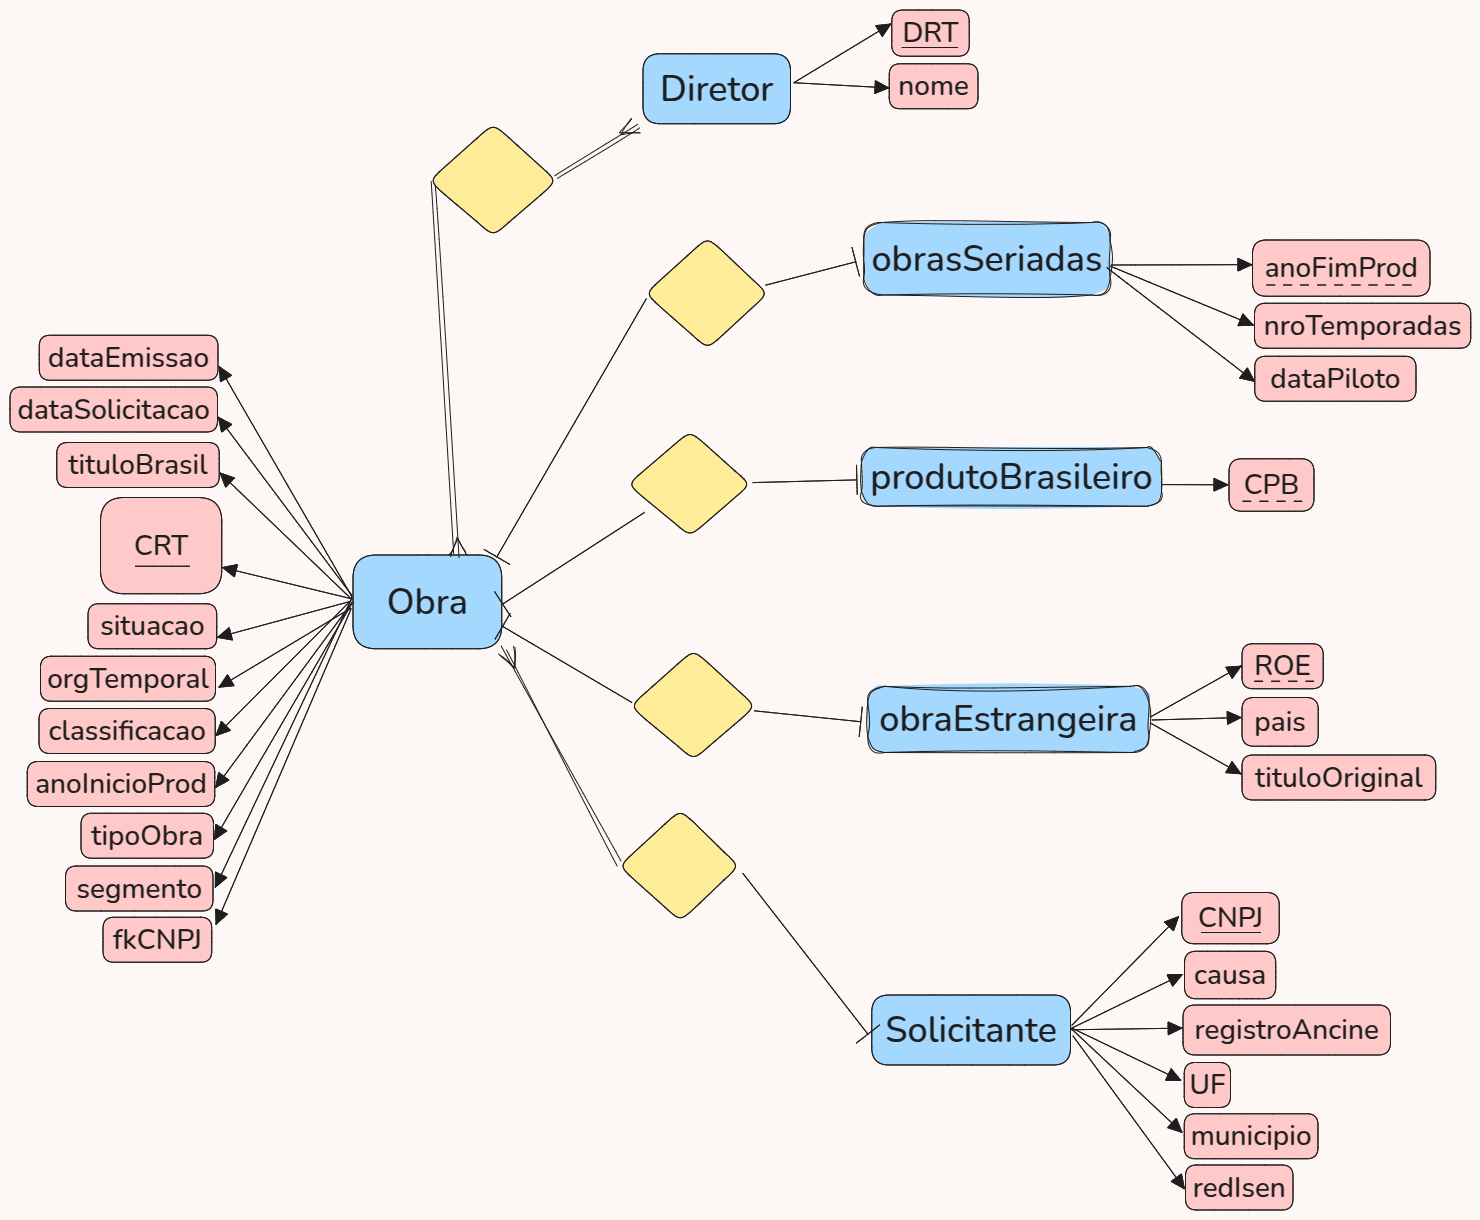

5) Diagrama relacional:

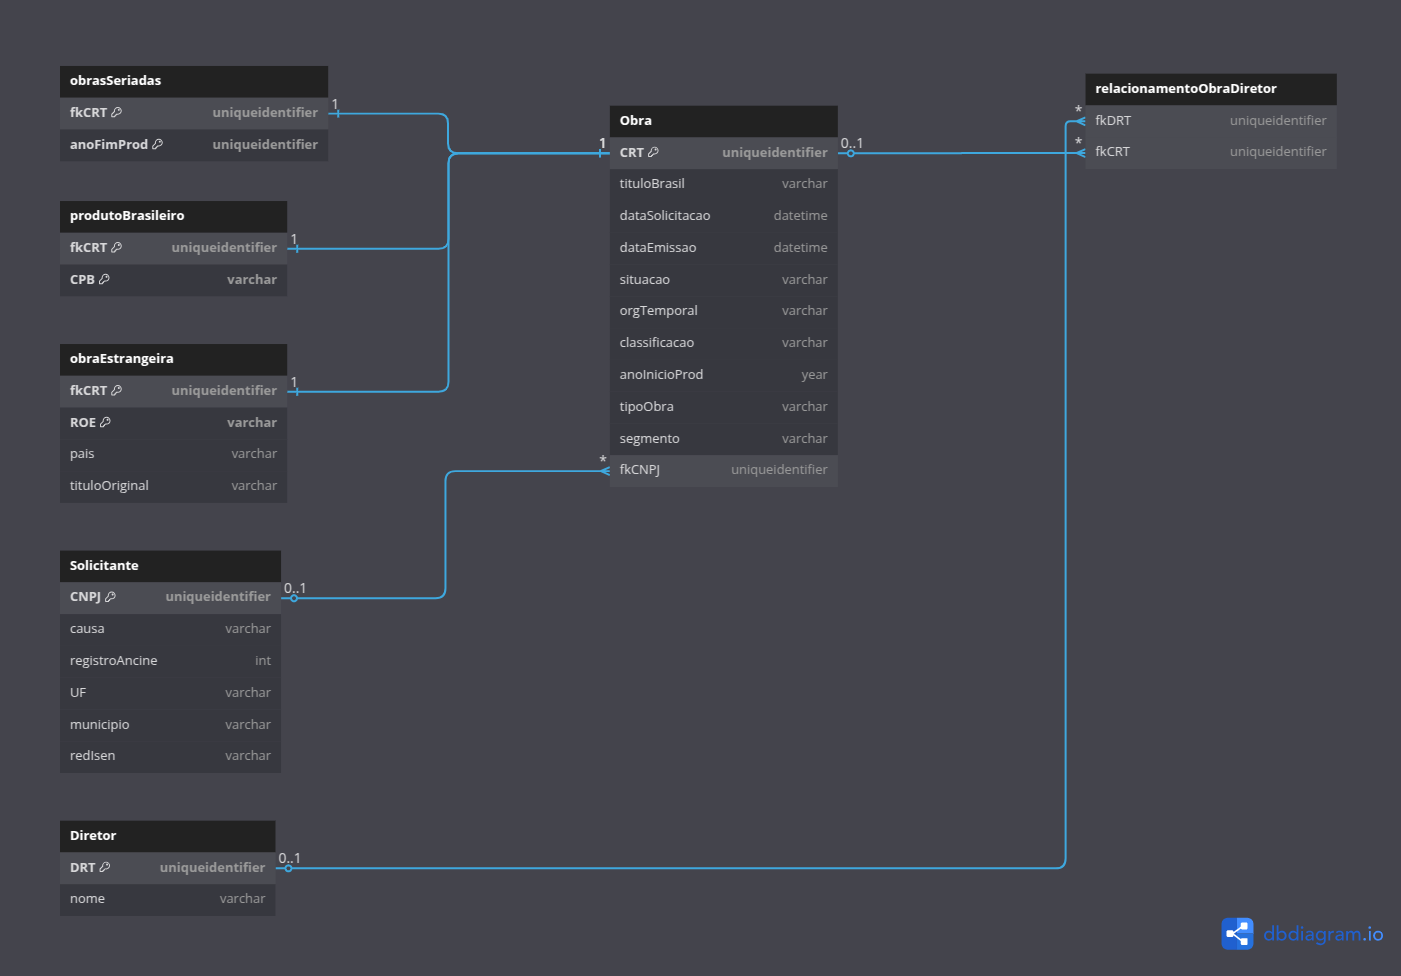

6) Consultas:

6.1) Duas consultas envolvendo relação e projeção:



  6.1.1) 1ª consulta:

6.1.2) 2ª consulta:



6.2) Três consultas envolvendo junção de duas relações:

6.2.1) 1ª consulta:



6.2.2) 2ª consulta:



6.2.3) 3ª consulta:



6.3) Três consultas envolvendo junção de três ou mais relações:

6.3.1) 1ª consulta:

6.3.2) 2ª consulta:

6.3.3) 3ª consulta:

6.4) Duas consultas envolvendo agregação sobre junção de duas ou mais relações:

6.4.1) 1ª consulta:

6.4.2) 2ª consulta: